# **Proyek Pengembangan Machine Learning: Analisis Sentimen**
**Nama:** Ghiffari Kenang Sagraha \
**Email:** ghiffarisagraha@apps.ipb.ac.id \
**ID Dicoding:** ghiffariks 

# 1. Import Library and Dependencies

In [3]:
%pip install sastrawi

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime as dt  
import re  
import string 
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia
import nltk 
from io import StringIO
import csv
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Input
from sklearn.model_selection import train_test_split
import gensim
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping

In [6]:
nltk.download('punkt')  
nltk.download('stopwords')  
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

seed = 0
np.random.seed(seed) 
pd.options.mode.chained_assignment = None  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ghiffari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ghiffari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ghiffari\AppData\Roaming\nltk_data...


# 2. Data Labelling

In [8]:
import pandas as pd
import copy

#Loading data dan Cleaning
df_app = pd.read_csv('./ulasan_aplikasi.csv')
clean_df = df_app.dropna(subset=['content'])
clean_df = clean_df[['content']] #Fokus hanya mengambil konten dari reviewnya -> problem NLP

In [9]:
clean_df

,content
0,sangat lumayan. tapi sy baru sih. blom tahu ke...
1,saya suka gopay karena murah dan saldo tetap a...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ..."
3,Aplikasinya membingunkan. Semua fiturnya harus...
4,kenapa saya teransaksi tf ke e'walet tidak ber...
...,...
89995,gopay memang oke
89996,gopay komplit dah
89997,Saya kurang beruntung
89998,Mudah dipakai


In [10]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [21]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text):
    return text.split()
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
 
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
 
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
 
    polarity=''
 
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
 
    return score, polarity

def aggregate_preprocess(clean_df):
    clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
    clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
    clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
    clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
    clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
    clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

    results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
    results = list(zip(*results))
    clean_df['polarity_score'] = results[0]
    clean_df['polarity'] = results[1]
    
    return clean_df

In [85]:
clean_df = aggregate_preprocess(clean_df)
print(clean_df['polarity'].value_counts())

polarity
positive    42089
negative    30813
neutral     17098
Name: count, dtype: int64


# 3. Eksplorasi Data

In [24]:
clean_df

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,sangat lumayan. tapi sy baru sih. blom tahu ke...,sangat lumayan tapi sy baru sih blom tahu ke a...,sangat lumayan tapi sy baru sih blom tahu ke a...,sangat lumayan tapi sy baru sih blom tahu ke a...,"[sangat, lumayan, tapi, sy, baru, sih, blom, t...","[lumayan, sy, blom, aman, akun, mudah, mudahan...",lumayan sy blom aman akun mudah mudahan aman j...,-8,negative
1,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...,8,positive
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu hari...,"[kecewa, udah, top, up, gak, masuk, masuk, nun...","[kecewa, udah, top, masuk, masuk, nunggu, hari...",kecewa udah top masuk masuk nunggu harikalo in...,-7,negative
3,Aplikasinya membingunkan. Semua fiturnya harus...,Aplikasinya membingunkan Semua fiturnya harus ...,aplikasinya membingunkan semua fiturnya harus ...,aplikasinya membingunkan semua fiturnya harus ...,"[aplikasinya, membingunkan, semua, fiturnya, h...","[aplikasinya, membingunkan, fiturnya, scrol, k...",aplikasinya membingunkan fiturnya scrol kebawa...,8,positive
4,kenapa saya teransaksi tf ke e'walet tidak ber...,kenapa saya teransaksi tf ke ewalet tidak berh...,kenapa saya teransaksi tf ke ewalet tidak berh...,kenapa saya teransaksi tf ke ewalet tidak berh...,"[kenapa, saya, teransaksi, tf, ke, ewalet, tid...","[teransaksi, tf, ewalet, berhasil, proses, ter...",teransaksi tf ewalet berhasil proses teruss ua...,1,positive
...,...,...,...,...,...,...,...,...,...
89995,gopay memang oke,gopay memang oke,gopay memang oke,gopay memang oke,"[gopay, memang, oke]","[gopay, oke]",gopay oke,2,positive
89996,gopay komplit dah,gopay komplit dah,gopay komplit dah,gopay komplit dah,"[gopay, komplit, dah]","[gopay, komplit, dah]",gopay komplit dah,-3,negative
89997,Saya kurang beruntung,Saya kurang beruntung,saya kurang beruntung,saya kurang beruntung,"[saya, kurang, beruntung]",[beruntung],beruntung,4,positive
89998,Mudah dipakai,Mudah dipakai,mudah dipakai,mudah dipakai,"[mudah, dipakai]","[mudah, dipakai]",mudah dipakai,3,positive


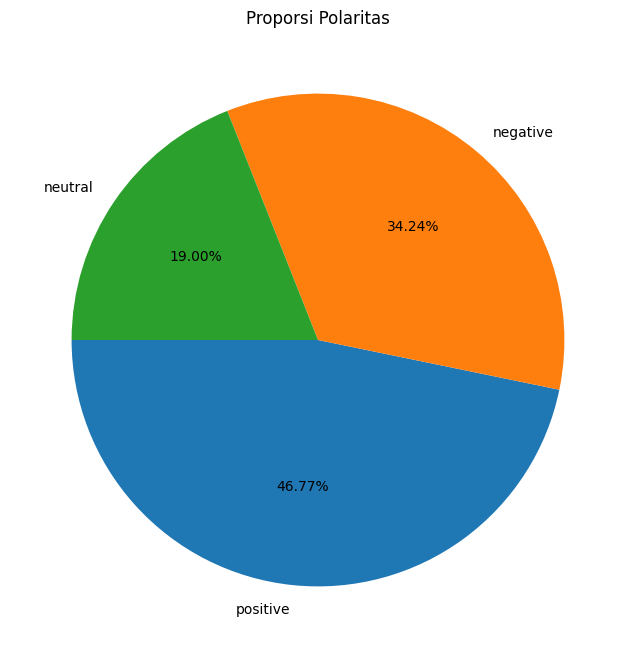

In [25]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.2f%%', startangle=180)
plt.title('Proporsi Polaritas')
plt.show()


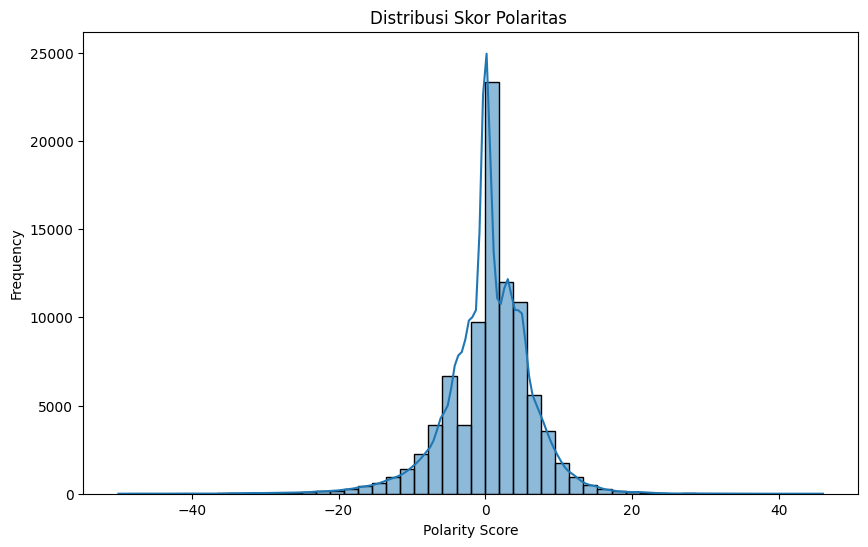

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['polarity_score'], bins=50, kde=True)
plt.title('Distribusi Skor Polaritas ')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

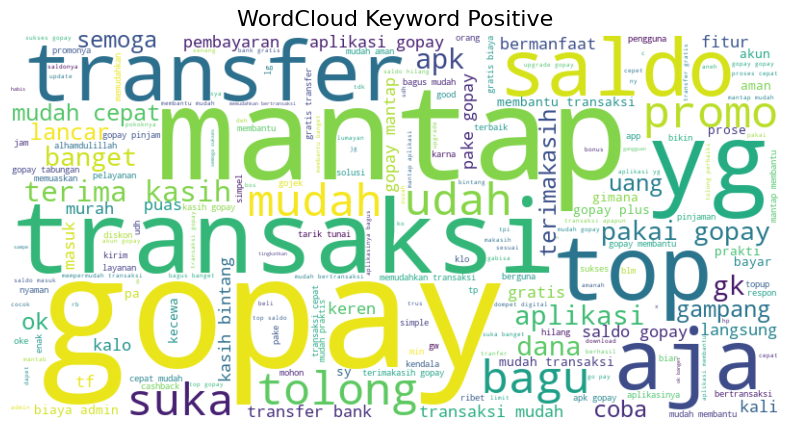

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Membuat Wordcloud
all_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Keyword Positive", fontsize=16)
plt.show()


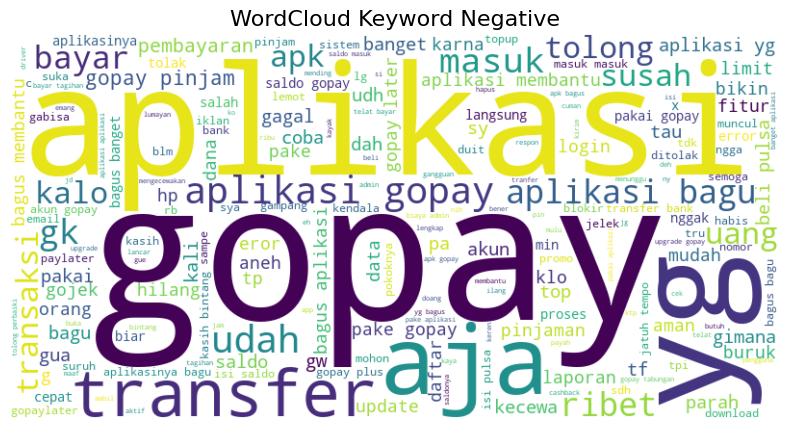

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Membuat Wordcloud
all_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Keyword Negative", fontsize=16)
plt.show()


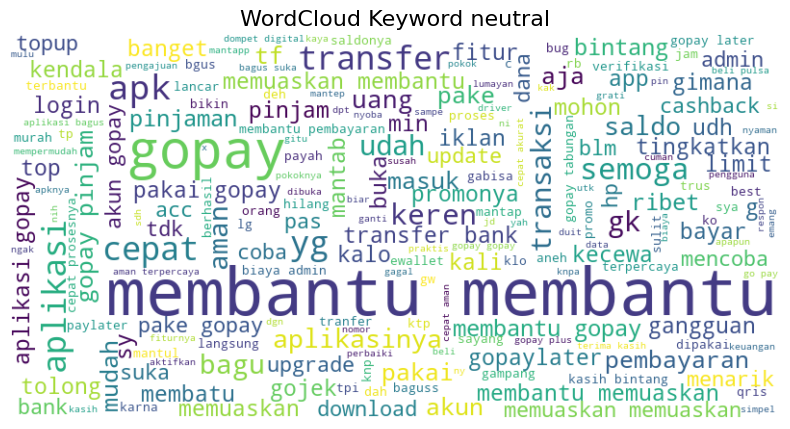

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Membuat Wordcloud
all_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Keyword neutral", fontsize=16)
plt.show()


Hasil labelling menggunakan lexicon positive dan negative menghasilkan proporsi paling banyak pada kelas positive, dilanjut negative, dan terakhir oleh neutral. ini menandakan Gopay sudah memiliki fitur-fitur yang cukup baik

# 4. Pelatihan Model

Dalam hal ini, akan digunakan 3 model yang memiliki ekstraksi fitur yang berbeda dan proporsi train-test berbeda

## 4.1 Dataset Pre-processing

In [30]:
texts = clean_df['text_akhir'].astype(str).tolist()
labels = clean_df['polarity'].tolist()

#Label encoding
le = LabelEncoder()
le.fit(labels)
y = le.transform(labels) 

# Tokenisasi
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_len = max([len(word) for word in sequences])
X = pad_sequences(sequences, maxlen=max_len, padding='post')

## 4.2 Model Training

### 4.2.1 Model Bi-Directional-Attention LSTM
dengan menggunakan training (70%), testing (20%), validatiion (10%). \
Ekstraksi fitur dengan menggunakan Embedding

In [76]:
#Membuat train-test-validation set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.10, stratify=y_trainval, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, SpatialDropout1D, Attention, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_bilstm_with_attention(vocab_size, max_len):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    attention = Attention()([lstm_out, lstm_out])
    
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)
    
    dense = Dense(64, activation='relu')(context_vector)
    output = Dense(3, activation='softmax')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


vocab_size = len(tokenizer.word_index) + 1
model_BiLSTM = build_bilstm_with_attention(vocab_size, max_len)
model_BiLSTM.summary()

history_BiLSTM = model_BiLSTM.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 75, 128)   │  5,308,160 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 75, 256)   │    263,168 │ embedding_10[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_6         │ (None, 75, 256)   │          0 │ bidirectional_7[… │
│ (Attention)         │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256)       │          0 │ attention_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     16,448 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 3)         │        195 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,587,971 (21.32 MB)

 Trainable params: 5,587,971 (21.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 104s 391ms/step - accuracy: 0.4250 - loss: 2.5460 - val_accuracy: 0.6676 - val_loss: 0.7483
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 98s 386ms/step - accuracy: 0.7788 - loss: 0.7333 - val_accuracy: 0.8653 - val_loss: 0.3504
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 106s 416ms/step - accuracy: 0.9001 - loss: 0.3021 - val_accuracy: 0.9186 - val_loss: 0.2348
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 104s 410ms/step - accuracy: 0.9594 - loss: 0.1409 - val_accuracy: 0.9476 - val_loss: 0.1723
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 102s 403ms/step - accuracy: 0.9742 - loss: 0.0895 - val_accuracy: 0.9485 - val_loss: 0.1762
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 89s 348ms/step - accuracy: 0.9772 - loss: 0.0790 - val_accuracy: 0.9532 - val_loss: 0.1667
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 87s 344ms/step - accuracy: 0.9857 - loss: 0.0527 - val_accuracy: 0.9528 - val_loss: 0.1838
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 87s 343ms/step - accuracy: 0.9875 - los

563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step
              precision    recall  f1-score   support

    negative       0.94      0.98      0.96      6163
     neutral       0.86      0.89      0.88      3419
    positive       0.99      0.95      0.97      8418

    accuracy                           0.95     18000
   macro avg       0.93      0.94      0.93     18000
weighted avg       0.95      0.95      0.95     18000



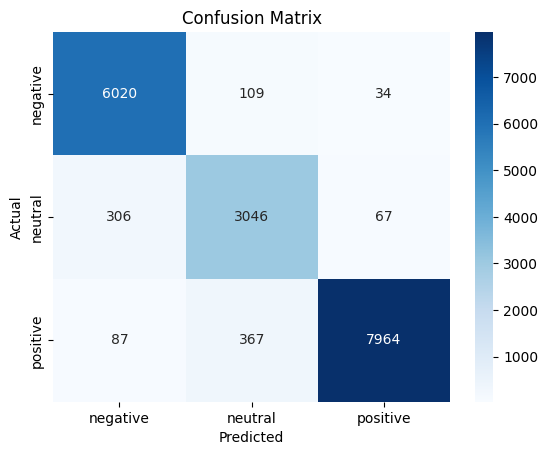

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model_BiLSTM.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [81]:
model_BiLSTM.save("model_bilstm.keras", save_format="keras")

### 4.2.2 Model Transformer (Attention Mechanism)
dengan menggunakan training (56%), testing (30%), validation (14%). \
Ekstraksi fitur dengan menggunakan Embedding

In [47]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import Input

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def build_transformer_model(vocab_size, max_len, num_heads=2, ff_dim=128):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attention)

    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(128)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(tokenizer.word_index) + 1

model_transformer = build_transformer_model(vocab_size, max_len)
model_transformer.summary()

history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 75, 128)   │  5,308,160 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 75, 128)   │     66,048 │ embedding_9[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 75, 128)   │          0 │ embedding_9[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 75, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 75, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 75, 128)   │     16,512 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 75, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 75, 128)   │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 3)         │        195 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,416,195 (20.66 MB)

 Trainable params: 5,416,195 (20.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 52s 248ms/step - accuracy: 0.3616 - loss: 1.1190 - val_accuracy: 0.5333 - val_loss: 0.9923
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.4720 - loss: 0.9973 - val_accuracy: 0.6089 - val_loss: 0.9205
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.5993 - loss: 0.8566 - val_accuracy: 0.8094 - val_loss: 0.4660
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - accuracy: 0.8698 - loss: 0.3834 - val_accuracy: 0.9119 - val_loss: 0.2531
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - accuracy: 0.9367 - loss: 0.2091 - val_accuracy: 0.9371 - val_loss: 0.2009
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 244ms/step - accuracy: 0.9636 - loss: 0.1333 - val_accuracy: 0.9501 - val_loss: 0.1688
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.9765 - loss: 0.0920 - val_accuracy: 0.9545 - val_loss: 0.1576
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - accuracy: 0.9832 - loss: 0

844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
              precision    recall  f1-score   support

    negative       0.98      0.96      0.97      9244
     neutral       0.90      0.93      0.92      5129
    positive       0.98      0.98      0.98     12627

    accuracy                           0.96     27000
   macro avg       0.95      0.96      0.95     27000
weighted avg       0.96      0.96      0.96     27000



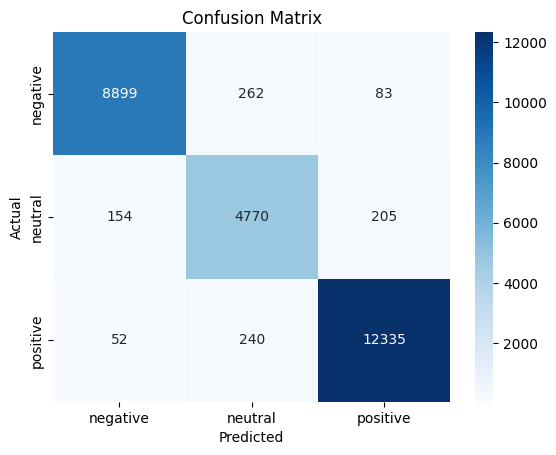

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred_prob = model_transformer.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 4.2.3 Model LightGBM - TFIDF
dengan menggunakan training (80%) dan testing (20%). \
ekstraksi fitur menggunakan Tf-idf

In [49]:
# Menggunakan TF-IDF untuk mengubah teks menjadi fitur numerik
tfidf = TfidfVectorizer(max_features=10000)  # Atau sesuaikan jumlah fitur
X_tfidf = tfidf.fit_transform(clean_df['text_akhir']).toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,  
    clean_df['polarity'],
    test_size=0.2,
    random_state=42,
    stratify=clean_df['polarity']
)

le = LabelEncoder()
y_train = np.array(le.fit_transform(y_train))
y_test = np.array(le.fit_transform(y_test))

In [50]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',  
    'num_class': 3, 
    'metric': 'multi_logloss',  
    'boosting_type': 'gbdt',  
    'num_leaves': 31,  
    'learning_rate': 0.05, 
    'feature_fraction': 0.9,  
}

callbacks = [
    log_evaluation(period=50),  
    early_stopping(stopping_rounds=50)  
]

clf = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000, callbacks=callbacks)

y_train_pred = clf.predict(X_train, num_iteration=clf.best_iteration)
y_train_pred_class = [np.argmax(x) for x in y_train_pred]  

print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_class)}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred_class, target_names=["negative", "neutral", "positive"]))

y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
y_pred_class = [np.argmax(x) for x in y_pred]  

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class, target_names=["negative", "neutral", "positive"]))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87366
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 1914
[LightGBM] [Info] Start training from score -1.071889
[LightGBM] [Info] Start training from score -1.660804
[LightGBM] [Info] Start training from score -0.760029
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.519591
[100]	valid_0's multi_logloss: 0.431172
[150]	valid_0's multi_logloss: 0.387069
[200]	valid_0's multi_logloss: 0.358639
[250]	valid_0's multi_logloss: 0.337866
[300]	valid_0's multi_logloss: 0.321326
[350]	valid_0's multi_logloss: 0.307871
[400]	valid_0's multi_logloss: 0.296599
[450]	valid_0's multi_logloss: 0.287051
[500]	valid_0's multi_logloss: 0.278848
[550]	valid_0's multi_

In [51]:
import joblib
joblib.dump(tfidf, "tfidf_model.pkl")
joblib.dump(clf, "lightgbm_model.pkl")

['lightgbm_model.pkl']

# 5. Inference

In [84]:
text_baru = [
    "gopay memang oke, luar biasa, saya senang menggunakan Gopay. Keren banget!",
    "Aplikasinya membingunkan, payah dan buruk sekali, sangat kecewa menggunakan Gopay",
    "gopay biasa saja sejauh ini, masih kurang beberapa fitur yang terkendala dan gangguan, harap diperbaiki lagi"
]

labels = ["positive", "negative", "neutral"]

#ekstraksi fitur
text_baru = pd.DataFrame(text_baru).iloc[:,0].\
    apply(cleaningText).apply(casefoldingText).\
    apply(fix_slangwords).apply(tokenizingText).\
    apply(filteringText).apply(toSentence).tolist()
    
new_sequences = tokenizer.texts_to_sequences(text_baru)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_len)

#Membuat prediksi
prediksi_bilstm = model_BiLSTM.predict(new_padded_sequences)
prediksi_transf = model_transformer.predict(new_padded_sequences)

#Mendapatkan label
predicted_bilstm = np.argmax(prediksi_bilstm, axis=1)
predicted_transf = np.argmax(prediksi_transf, axis=1)
predicted_labels_bilstm = le.inverse_transform(predicted_bilstm)
predicted_labels_transf = le.inverse_transform(predicted_transf)

#hasil prediksi
for text, true_label, label_bilstm, label_transf in zip(text_baru, labels, predicted_labels_bilstm, predicted_labels_transf):
    print(f"""\nText: \"{text}\"\nTrue Label: {true_label}\nPredicted Label (Bi-LSTM): {label_bilstm}\nPredicted Label (Transformer): {label_transf}""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Text: "gopay oke senang gopay keren banget"
True Label: positive
Predicted Label (Bi-LSTM): neutral
Predicted Label (Transformer): positive

Text: "aplikasinya membingunkan payah buruk kecewa gopay"
True Label: negative
Predicted Label (Bi-LSTM): neutral
Predicted Label (Transformer): negative

Text: "gopay fitur terkendala gangguan harap diperbaiki"
True Label: neutral
Predicted Label (Bi-LSTM): neutral
Predicted Label (Transformer): neutral


In [53]:
#Load Model
tfidf = joblib.load("tfidf_model.pkl")
clf = joblib.load("lightgbm_model.pkl")

X_infer = tfidf.transform(text_baru)
y_infer_prob = clf.predict(X_infer, num_iteration=clf.best_iteration, predict_disable_shape_check=True)
y_infer_class = np.argmax(y_infer_prob, axis=1)
labelencoder = LabelEncoder()
labelencoder.fit(["positive", "negative", "neutral"])

hasil_label = labelencoder.inverse_transform(y_infer_class)
for lab in hasil_label:
    print(f"Hasil prediksi kalimat: {lab}")

Hasil prediksi kalimat: positive
Hasil prediksi kalimat: negative
Hasil prediksi kalimat: neutral
